# CS613 Final Project - Parkinsons Disease Dataset

In [1]:
import numpy as np
import pandas as pd

# -------------------------
# Load Data
# -------------------------
df = pd.read_csv("/work/parkinsons_disease_data.csv")

# Drop identifier / confidential columns
df = df.drop(columns=["PatientID", "DoctorInCharge"], errors="ignore")

# -------------------------
# Handle Missing Values
# -------------------------
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].nunique() > 2:  # continuous
            df[col].fillna(df[col].mean(), inplace=True)
        else:  # binary/categorical
            df[col].fillna(df[col].mode()[0], inplace=True)

# -------------------------
# Split Features and Labels
# -------------------------
X = df.drop(columns=["Diagnosis"]).values
y = df["Diagnosis"].values

# -------------------------
# Feature Scaling (z-score)
# -------------------------
def standardize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1  # prevent division by zero
    return (X - mean) / std, mean, std

X_scaled, X_mean, X_std = standardize(X)

# -------------------------
# Train/Test Split
# -------------------------
def train_test_split(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    split = int(X.shape[0] * (1 - test_size))
    train_idx, test_idx = idx[:split], idx[split:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (1684, 32) (1684,)
Test shape: (421, 32) (421,)


/tmp/ipykernel_44/1320631326.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Diagnosis", data=df, palette="Set2")


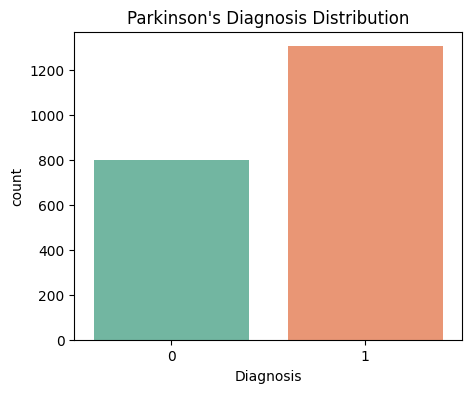

                                mean         std         min         max
Age                        69.601900   11.594511   50.000000   89.000000
Gender                      0.492637    0.500065    0.000000    1.000000
Ethnicity                   0.692637    1.003827    0.000000    3.000000
EducationLevel              1.337292    0.895840    0.000000    3.000000
BMI                        27.209493    7.208099   15.008333   39.999887
Smoking                     0.296437    0.456795    0.000000    1.000000
AlcoholConsumption         10.040413    5.687014    0.002228   19.988866
PhysicalActivity            5.016674    2.890919    0.004157    9.995255
DietQuality                 4.912901    2.872115    0.000011    9.995864
SleepQuality                6.996639    1.753065    4.000497    9.999821
FamilyHistoryParkinsons     0.145843    0.353033    0.000000    1.000000
TraumaticBrainInjury        0.106413    0.308439    0.000000    1.000000
Hypertension                0.145843    0.353033   

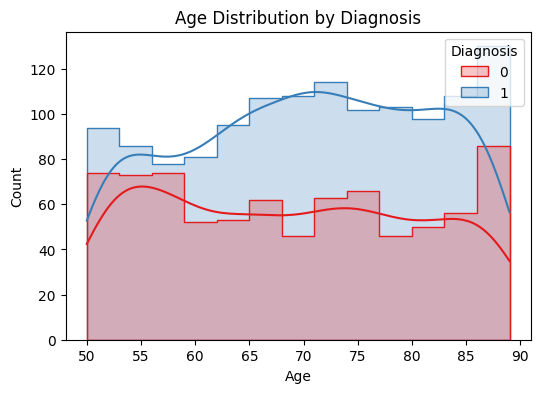

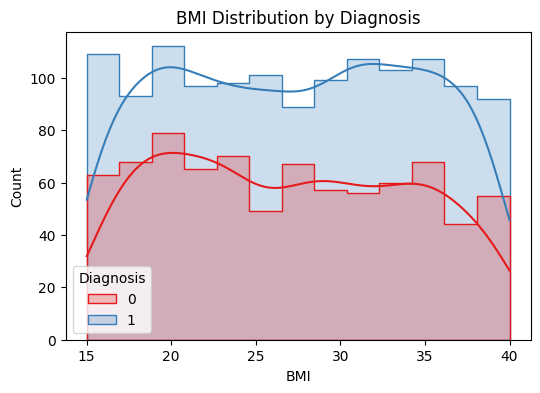

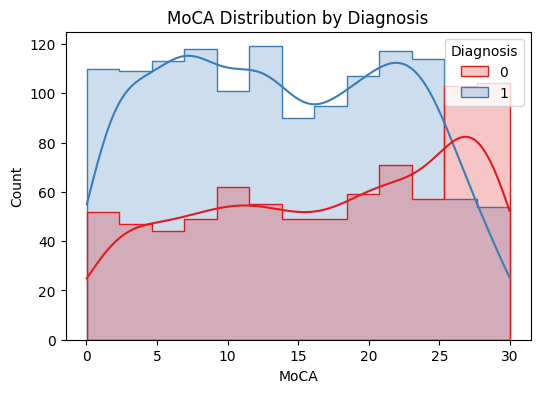

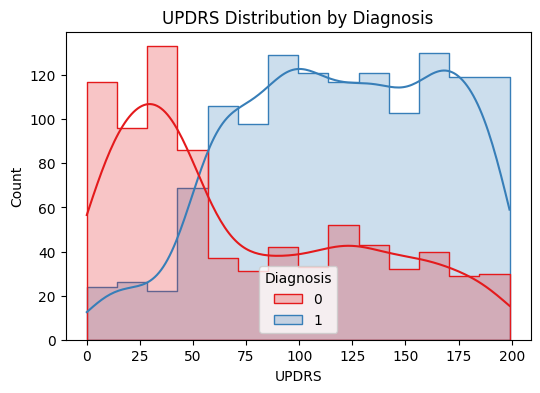

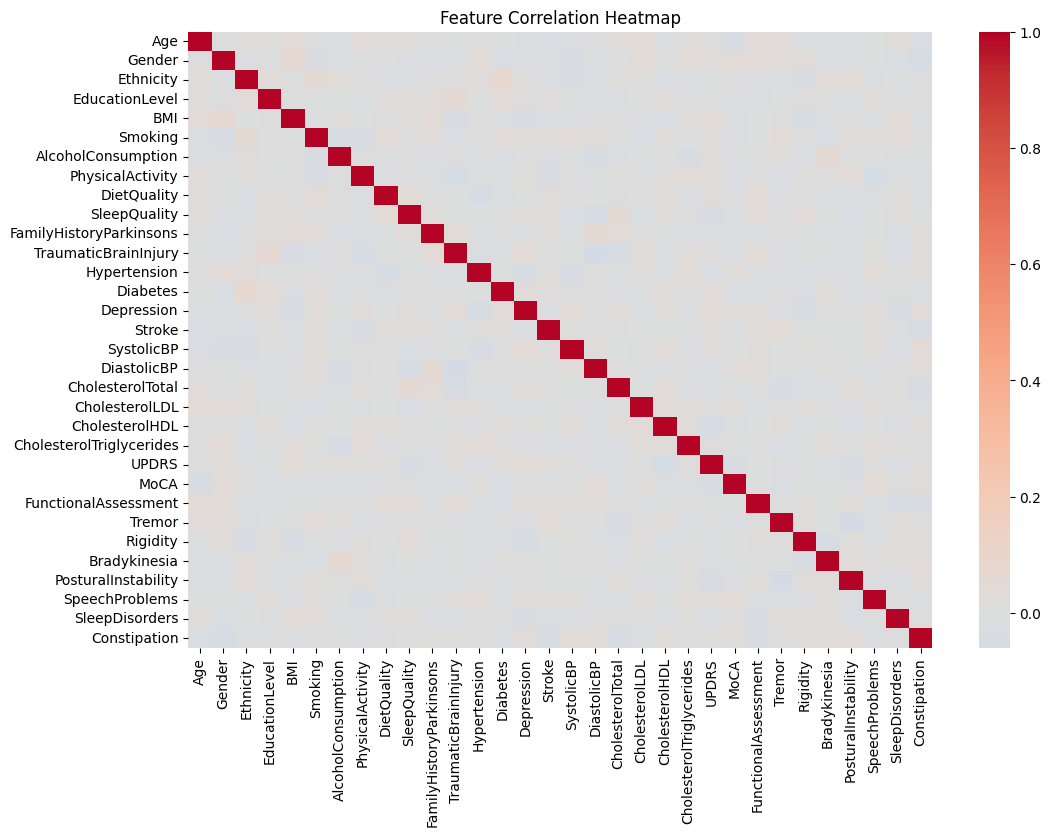

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Target Distribution
# -------------------------
plt.figure(figsize=(5,4))
sns.countplot(x="Diagnosis", data=df, palette="Set2")
plt.title("Parkinson's Diagnosis Distribution")
plt.show()

# -------------------------
# 2. Descriptive Stats
# -------------------------
print(df.describe().T[["mean","std","min","max"]])

# -------------------------
# 3. Histograms
# -------------------------
features_to_plot = ["Age", "BMI", "MoCA", "UPDRS"]

for feat in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=feat, hue="Diagnosis", kde=True, element="step", palette="Set1")
    plt.title(f"{feat} Distribution by Diagnosis")
    plt.show()

# -------------------------
# 4. Correlation Heatmap
# -------------------------
plt.figure(figsize=(12,8))
corr = df.drop(columns=["Diagnosis"]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


## Logistic Regression

In [3]:
# shuffle rows
def train_test_split(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    split = int(X.shape[0] * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def standardize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    return (X - mean) / std, mean, std

def apply_standardize(X, mean, std):
    return (X - mean) / std

class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # update weights
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i, true_label in enumerate(classes):
        for j, pred_label in enumerate(classes):
            matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
    return matrix

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + 1e-10)   # avoid division by zero

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-10)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + 1e-10)


In [4]:
# Assuming df is your DataFrame and "Diagnosis" is the target
X = df.drop(columns=["Diagnosis"]).values
y = df["Diagnosis"].values

# standardize
X, mean, std = standardize(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train logistic regression
log_reg = LogisticRegressionScratch(lr=0.01, n_iter=2000)
log_reg.fit(X_train, y_train)

# predictions
y_pred = log_reg.predict(X_test)


# predictions already done
print("Logistic Regression Accuracy:", accuracy(y_test, y_pred))
print("Logistic Regression Precision:", precision(y_test, y_pred))
print("Logistic Regression Recall:", recall(y_test, y_pred))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8147268408551069
Logistic Regression Precision: 0.8145454545451584
Logistic Regression Recall: 0.8924302788841066
Logistic Regression F1 Score: 0.8517110265657499
Logistic Regression Confusion Matrix:
 [[119  51]
 [ 27 224]]


## Gaussian Naive Bayes

In [5]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.vars = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.vars[c] = np.var(X_c, axis=0) + 1e-6   # avoid zero division
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def gaussian_pdf(self, class_idx, x):
        mean = self.means[class_idx]
        var = self.vars[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict_single(self, x):
        posteriors = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            cond_prob = np.sum(np.log(self.gaussian_pdf(c, x)))
            posterior = prior + cond_prob
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

In [6]:
# Train
nb = GaussianNaiveBayes()
nb.fit(X_train, y_train)

# Predict
y_pred_nb = nb.predict(X_test)

# Evaluate
print("Naive Bayes Accuracy:", accuracy(y_test, y_pred_nb))
print("Naive Bayes Precision:", precision(y_test, y_pred_nb))
print("Naive Bayes Recall:", recall(y_test, y_pred_nb))
print("Naive Bayes F1 Score:", f1_score(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.7885985748218527
Naive Bayes Precision: 0.8115384615381495
Naive Bayes Recall: 0.8406374501988683
Naive Bayes F1 Score: 0.8258317024937237
Naive Bayes Confusion Matrix:
 [[121  49]
 [ 40 211]]


## KNN

In [7]:
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict_single(self, x):
        # Compute distances
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Get k nearest neighbors
        k_idx = np.argsort(distances)[:self.k]
        k_neighbor_labels = self.y_train[k_idx]

        # Majority vote
        values, counts = np.unique(k_neighbor_labels, return_counts=True)
        return values[np.argmax(counts)]

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

In [8]:
# Train
knn = KNN(k=5)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate
print("KNN Accuracy:", accuracy(y_test, y_pred_knn))
print("KNN Precision:", precision(y_test, y_pred_knn))
print("KNN Recall:", recall(y_test, y_pred_knn))
print("KNN F1 Score:", f1_score(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN Accuracy: 0.7339667458432304
KNN Precision: 0.7583643122673761
KNN Recall: 0.81274900398374
KNN F1 Score: 0.7846153845651429
KNN Confusion Matrix:
 [[105  65]
 [ 47 204]]


## Decision Tree

In [9]:
from collections import Counter
import numpy as np

# -------------------------
# Decision Tree (Entropy-based)
# -------------------------
def entropy(y):
    """Calculate entropy of labels y."""
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

def information_gain(y, X_column, threshold):
    """Calculate information gain from a split on feature X_column at threshold."""
    parent_entropy = entropy(y)

    # split
    left_idx = np.argwhere(X_column <= threshold).flatten()
    right_idx = np.argwhere(X_column > threshold).flatten()

    if len(left_idx) == 0 or len(right_idx) == 0:
        return 0

    n = len(y)
    n_left, n_right = len(left_idx), len(right_idx)
    e_left, e_right = entropy(y[left_idx]), entropy(y[right_idx])

    child_entropy = (n_left/n) * e_left + (n_right/n) * e_right
    return parent_entropy - child_entropy

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping conditions
        if (depth >= self.max_depth 
            or n_labels == 1 
            or n_samples < self.min_samples_split):
            leaf_value = self.most_common_label(y)
            return self.Node(value=leaf_value)

        # find best split
        best_feat, best_thresh, best_gain = None, None, -1
        for feat in range(n_features):
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                gain = information_gain(y, X[:, feat], thresh)
                if gain > best_gain:
                    best_feat, best_thresh, best_gain = feat, thresh, gain

        if best_gain == 0:
            leaf_value = self.most_common_label(y)
            return self.Node(value=leaf_value)

        # recursive split
        left_idx = np.argwhere(X[:, best_feat] <= best_thresh).flatten()
        right_idx = np.argwhere(X[:, best_feat] > best_thresh).flatten()

        left = self.build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right = self.build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return self.Node(best_feat, best_thresh, left, right)

    def most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

In [10]:
# Train Decision Tree
dt_entropy = DecisionTree(max_depth=10)
dt_entropy.fit(X_train, y_train)
y_pred_dt = dt_entropy.predict(X_test)

print("\n--- Decision Tree (Entropy) ---")
print("Accuracy:", accuracy(y_test, y_pred_dt))
print("Precision:", precision(y_test, y_pred_dt))
print("Recall:", recall(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


--- Decision Tree (Entropy) ---
Accuracy: 0.8978622327790974
Precision: 0.9159999999996337
Recall: 0.9123505976091983
F1 Score: 0.9141716566362621
Confusion Matrix:
 [[149  21]
 [ 22 229]]


## Random Forest

In [11]:
# -------------------------
# Random Forest (Entropy Trees)
# -------------------------
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            n_feats = self.n_features or int(np.sqrt(X.shape[1]))
            feat_idxs = np.random.choice(X.shape[1], n_feats, replace=False)

            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample[:, feat_idxs], y_sample)

            self.trees.append((tree, feat_idxs))

    def predict(self, X):
        tree_preds = np.array([tree.predict(X[:, feat_idxs]) for tree, feat_idxs in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)  # shape: (n_samples, n_trees)
        y_pred = [Counter(row).most_common(1)[0][0] for row in tree_preds]
        return np.array(y_pred)

In [12]:
# Train Random Forest
rf_entropy = RandomForest(n_trees=10, max_depth=10)
rf_entropy.fit(X_train, y_train)
y_pred_rf = rf_entropy.predict(X_test)

print("\n--- Random Forest (Entropy) ---")
print("Accuracy:", accuracy(y_test, y_pred_rf))
print("Precision:", precision(y_test, y_pred_rf))
print("Recall:", recall(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


--- Random Forest (Entropy) ---
Accuracy: 0.6223277909738717
Precision: 0.6191709844557982
Recall: 0.9521912350593816
F1 Score: 0.750392464630189
Confusion Matrix:
 [[ 23 147]
 [ 12 239]]


In [13]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy(y_true, y_pred))
    print("Precision:", precision(y_true, y_pred))
    print("Recall:", recall(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [14]:
evaluate_model("Logistic Regression", y_test, log_reg.predict(X_test))
evaluate_model("Naive Bayes", y_test, nb.predict(X_test))
evaluate_model("KNN", y_test, knn.predict(X_test))
evaluate_model("Decision Tree (Entropy)", y_test, dt_entropy.predict(X_test))
evaluate_model("Random Forest (Entropy)", y_test, rf_entropy.predict(X_test))


Logistic Regression
Accuracy: 0.8147268408551069
Precision: 0.8145454545451584
Recall: 0.8924302788841066
F1 Score: 0.8517110265657499
Confusion Matrix:
 [[119  51]
 [ 27 224]]

Naive Bayes
Accuracy: 0.7885985748218527
Precision: 0.8115384615381495
Recall: 0.8406374501988683
F1 Score: 0.8258317024937237
Confusion Matrix:
 [[121  49]
 [ 40 211]]

KNN
Accuracy: 0.7339667458432304
Precision: 0.7583643122673761
Recall: 0.81274900398374
F1 Score: 0.7846153845651429
Confusion Matrix:
 [[105  65]
 [ 47 204]]

Decision Tree (Entropy)
Accuracy: 0.8978622327790974
Precision: 0.9159999999996337
Recall: 0.9123505976091983
F1 Score: 0.9141716566362621
Confusion Matrix:
 [[149  21]
 [ 22 229]]

Random Forest (Entropy)
Accuracy: 0.6223277909738717
Precision: 0.6191709844557982
Recall: 0.9521912350593816
F1 Score: 0.750392464630189
Confusion Matrix:
 [[ 23 147]
 [ 12 239]]


In [15]:
class VotingEnsemble:
    def __init__(self, models):
        self.models = models  # list of (name, model)

    def predict(self, X):
        preds = np.array([model.predict(X) for _, model in self.models])
        # majority vote across models (axis=0: sample-wise)
        final_preds = []
        for i in range(preds.shape[1]):
            votes, counts = np.unique(preds[:, i], return_counts=True)
            final_preds.append(votes[np.argmax(counts)])
        return np.array(final_preds)

# Example usage
ensemble = VotingEnsemble([
    ("LogReg", log_reg),
    ("NaiveBayes", nb),
    ("KNN", knn),
    ("DecisionTree", dt_entropy)
])

y_pred_ensemble = ensemble.predict(X_test)
evaluate_model("Voting Ensemble", y_test, y_pred_ensemble)


Voting Ensemble
Accuracy: 0.8527315914489311
Precision: 0.892116182572244
Recall: 0.8565737051789416
F1 Score: 0.8739837397870638
Confusion Matrix:
 [[144  26]
 [ 36 215]]
